In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

import datetime
import matplotlib 
from matplotlib import rcParams

import seaborn as sns
import statsmodels.api as sm
import ruptures as rpt
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

In [2]:
# Set the font family to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams.update({'font.size': 16})

### Topics over Time

In [3]:
data = pd.read_csv('topic_modelling_data.csv')

In [4]:
# Remove the reviews that are assigned to Topic 0
data = data[data['dominant_topic'] != 0]

In [5]:
# Filter the data
before_covid = data[(data['year_flown'] >= 2017) & (data['year_flown'] <= 2019)]
during_after_covid = data[(data['year_flown'] >= 2020) & (data['year_flown'] <= 2022)]

# Add a column indicating before or during COVID
before_covid = before_covid.assign(before_during_covid=0)
during_after_covid = during_after_covid.assign(before_during_covid=1)

# Concatenate
data = pd.concat([before_covid, during_after_covid])
data = data.reset_index(drop=True)

In [6]:
# Filter the data for each period
period1_data = data[data['before_during_covid'] == 0]
period2_data = data[data['before_during_covid'] == 1]

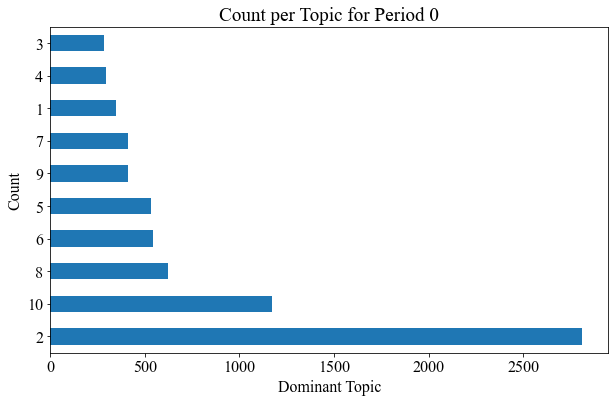

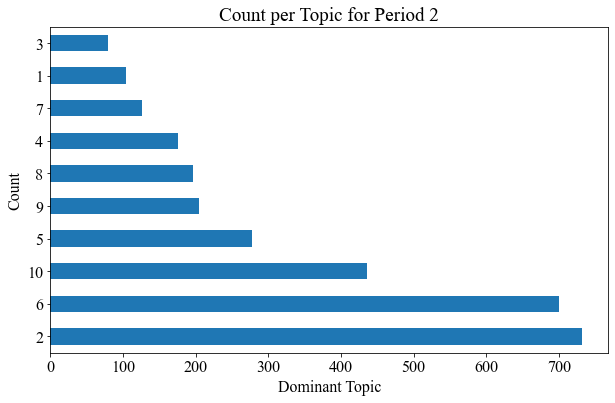

In [7]:
# Group the data by 'dominant_topic' and count the occurrences
topic_counts = period1_data['dominant_topic'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size
topic_counts.plot(kind='barh')
plt.title('Count per Topic for Period 0')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.show()

# Group the data by 'dominant_topic' and count the occurrences
topic_counts = period2_data['dominant_topic'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size
topic_counts.plot(kind='barh')
plt.title('Count per Topic for Period 2')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.show()

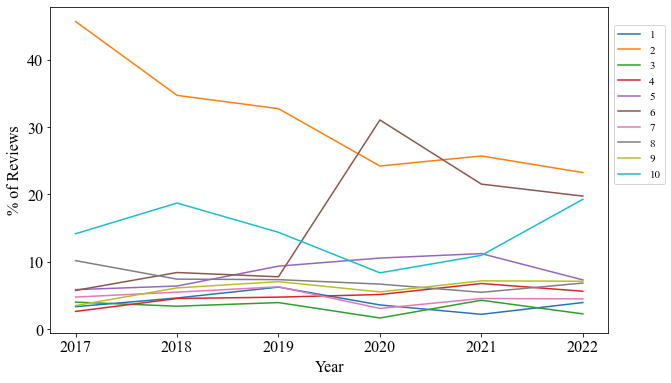

In [8]:
# Group data by 'year_flown' and 'dominant_topic' and count the reviews in each group
topic_counts = data.groupby(['year_flown', 'dominant_topic']).size().unstack()

# Calculate the total number of reviews per year
year_totals = topic_counts.sum(axis=1)

# Convert year_totals
year_totals = year_totals.to_frame(name='review_count_y')

# Merge the topic counts and year totals dataframes
topic_percentages = pd.merge(topic_counts, year_totals, left_index=True, right_index=True)

# Calculate the percentage of reviews per topic per year
topic_percentages = topic_percentages.divide(topic_percentages['review_count_y'], axis=0) * 100

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

for topic in topic_percentages.columns[:-1]:
    ax.plot(topic_percentages.index, topic_percentages[topic], label=topic)

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('% of Reviews')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.7), fontsize='x-small')
plt.show()


NameError: name 'bar_width' is not defined

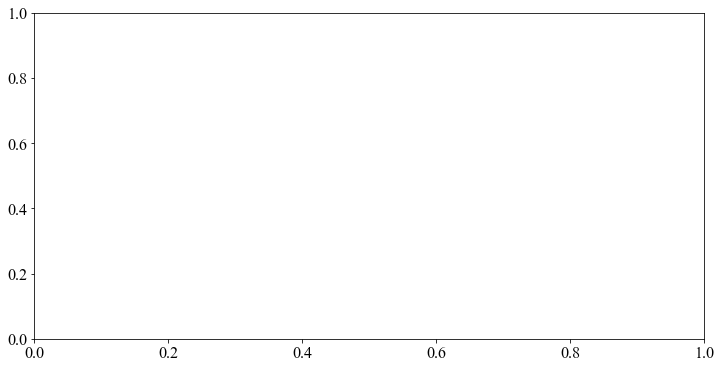

In [9]:

# Group the data by 'dominant_topic' and count the occurrences for period 1
topic_counts_period1 = period1_data['dominant_topic'].value_counts()

# Group the data by 'dominant_topic' and count the occurrences for period 2
topic_counts_period2 = period2_data['dominant_topic'].value_counts()

# Calculate the total number of reviews
total_reviews_period1 = topic_counts_period1.sum()
total_reviews_period2 = topic_counts_period2.sum()

# Get the unique topics
unique_topics = sorted(set(topic_counts_period1.index) | set(topic_counts_period2.index))

# Calculate the percentage of total reviews for each topic in period 1 and period 2
percentages_period1 = (topic_counts_period1 / total_reviews_period1) * 100
percentages_period2 = (topic_counts_period2 / total_reviews_period2) * 100

# Sort the data in ascending order
sorted_indices = np.argsort(percentages_period1.reindex(unique_topics))
sorted_unique_topics = np.array(unique_topics)[sorted_indices]

# Calculate the positions for the bars
r = np.arange(len(unique_topics))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars for period 1
ax.bar(r, percentages_period1.reindex(sorted_unique_topics), width=bar_width, color='grey', label='Period 1', edgecolor='white')

# Plot the bars for period 2
ax.bar(r + bar_width, percentages_period2.reindex(sorted_unique_topics), width=bar_width, color='darkblue', label='Period 2', edgecolor='white')

# Set the x-axis limits
ax.set_xlim(0, len(unique_topics))

# Set the x-axis labels to the topics
ax.set_xticks(r + bar_width / 2)
ax.set_xticklabels(sorted_unique_topics)

# Set the labels and title
ax.set_xlabel('Topic Numbers')
ax.set_ylabel('% of Total Reviews')
ax.set_title('% of Total Reviews per Topic')

# Add a legend
ax.legend()

# Show the combined plot
plt.tight_layout()
plt.show()



In [32]:
# Group the data by 'dominant_topic' and count the occurrences for period 1
topic_counts_period1 = period1_data['dominant_topic'].value_counts()

# Group the data by 'dominant_topic' and count the occurrences for period 2
topic_counts_period2 = period2_data['dominant_topic'].value_counts()

# Calculate the total number of reviews
total_reviews_period1 = topic_counts_period1.sum()
total_reviews_period2 = topic_counts_period2.sum()

# Get the unique topics
unique_topics = sorted(set(topic_counts_period1.index) | set(topic_counts_period2.index))

# Calculate the percentage of total reviews for each topic in period 1 and period 2
percentages_period1 = (topic_counts_period1 / total_reviews_period1) * 100
percentages_period2 = (topic_counts_period2 / total_reviews_period2) * 100

# Sort the data in ascending order
sorted_indices = np.argsort(percentages_period1.reindex(unique_topics))
sorted_unique_topics = np.array(unique_topics)[sorted_indices]

# Create a DataFrame to store the information
df = pd.DataFrame({
    'Topic': sorted_unique_topics,
    'Period 1': percentages_period1.reindex(sorted_unique_topics),
    'Period 2': percentages_period2.reindex(sorted_unique_topics)
})

# Set the Topic column as the index
df.set_index('Topic', inplace=True)

# Display the DataFrame as a table
print(df)


        Period 1   Period 2
Topic                      
3       3.799003   2.640264
4       3.974134   5.808581
1       4.715075   3.432343
7       5.509902   4.158416
9       5.536845   6.732673
5       7.166914   9.141914
6       7.315102  23.102310
8       8.352418   6.468647
10     15.802236  14.389439
2      37.828371  24.125413


C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\4244186791.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\4244186791.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\4244186791.py:24: SettingWithCopyWarning: 
A value is tryin

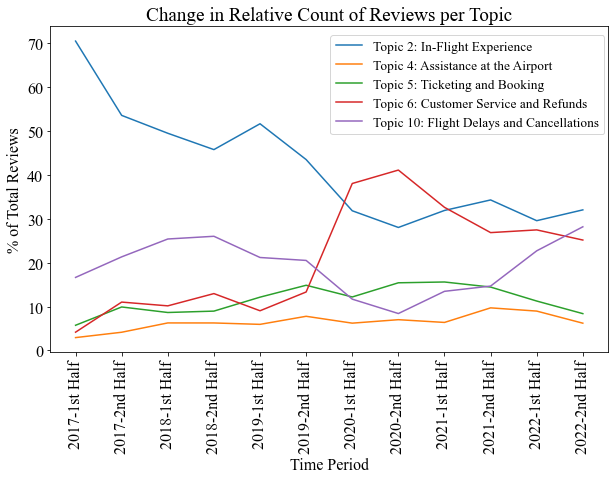

In [55]:
# Specify the four topics of interest
topics_of_interest = [
    'Topic 2: In-Flight Experience',
    'Topic 4: Assistance at the Airport',
    'Topic 5: Ticketing and Booking',
    'Topic 6: Customer Service and Refunds',
    'Topic 10: Flight Delays and Cancellations']

# Filter the data DataFrame to include only the topics of interest
filtered_data = data[data['topic_name'].isin(topics_of_interest)]

# Extract year and month from the 'date_flown' column
filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month

# Define a function to map month to half-year
def map_to_half_year(month):
    if month <= 6:
        return '1st Half'
    else:
        return '2nd Half'

# Map the month to half-year
filtered_data['half_year'] = filtered_data['month_flown'].map(map_to_half_year)

# Group the filtered data by 'year_flown', 'half_year', and 'topic_name' and count the reviews in each group
topic_counts = filtered_data.groupby(['year_flown', 'half_year', 'topic_name']).size().unstack()

# Calculate the total number of reviews per half-year
half_year_totals = filtered_data.groupby(['year_flown', 'half_year']).size()

# Convert half_year_totals to a DataFrame with a named column
half_year_totals = half_year_totals.to_frame(name='review_count_hy')

# Merge the topic counts and half-year totals dataframes
topic_percentages = pd.merge(topic_counts, half_year_totals, left_index=True, right_index=True)

# Calculate the percentage of reviews per topic per half-year
topic_percentages = topic_percentages.div(topic_percentages['review_count_hy'], axis=0) * 100

# Convert the multi-index into formatted strings for year and half-year
topic_percentages.index = topic_percentages.index.map(lambda x: f"{x[0]}-{x[1]}")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

for topic in topics_of_interest:
    ax.plot(topic_percentages.index, topic_percentages[topic], label=topic)

ax.legend()
ax.set_xlabel('Time Period')
ax.set_ylabel('% of Total Reviews')
ax.set_title('Change in Relative Count of Reviews per Topic')
ax.legend(loc='center left', bbox_to_anchor=(0.49, 0.82), fontsize='small')
plt.xticks(rotation=90)
plt.show()


## Deepdive into change in Topic 6

In [55]:
nlp = spacy.load('en_core_web_sm')

def extract_adj_noun_combinations(review):
    doc = nlp(review)
    adj_noun_combinations = []

    for token in doc:
        if token.pos_ == 'ADJ' and token.head.pos_ == 'NOUN':
            adj_noun_combinations.append(f"{token.text} {token.head.text}")

    return adj_noun_combinations

In [56]:
df_topic_6 = data[data["dominant_topic"] == 6]

In [57]:
before_topic_6 = df_topic_6[df_topic_6["before_during_covid"] == 0]
during_topic_6 = df_topic_6[df_topic_6["before_during_covid"] == 1]

In [58]:
# before_topic_6

adj_noun_combinations = []

for review in before_topic_6['processed_review']:
    combinations = extract_adj_noun_combinations(review)
    adj_noun_combinations.extend(combinations)

# Count the frequency of adjective + noun combinations
combination_counts = Counter(adj_noun_combinations)

# Get the most common adjective + noun combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common adjective + noun combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


next day: 49
next flight: 29
same day: 20
several times: 19
full refund: 19
other airlines: 17
many times: 16
new flight: 16
new ticket: 16
few days: 16
poor service: 13
bad service: 13
multiple times: 13
worst service: 12
last minute: 12
first time: 11
same flight: 11
worst experience: 10
long time: 10
first flight: 10


In [60]:
# after_topic_6

adj_noun_combinations = []

for review in during_topic_6['processed_review']:
    combinations = extract_adj_noun_combinations(review)
    adj_noun_combinations.extend(combinations)

# Count the frequency of adjective + noun combinations
combination_counts = Counter(adj_noun_combinations)

# Get the most common adjective + noun combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common adjective + noun combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")

next day: 46
full refund: 34
worst experience: 26
multiple times: 24
worst service: 22
few days: 21
new flight: 20
several times: 18
last minute: 17
same day: 16
new ticket: 15
many times: 15
next flight: 14
few hours: 13
worst airline: 13
other airlines: 13
Worst service: 12
last time: 12
Turkish airlines: 12
first time: 11


## Combining Sentiment Analysis & Topic Modelling

In [69]:
# Group the data by 'period' and 'topic_names' and calculate the mean of 'compound_score'
avg_scores = round(data.groupby(['before_during_covid', 'topic_name'])['compound_score'].mean().reset_index(),2)

# Reshape the data to create a table with 'period' as columns and 'topic_names' as rows
score_table = avg_scores.pivot(index='topic_name', columns='before_during_covid', values='compound_score')

# Sort the table by the 'Topic' column in ascending order
score_table = score_table.sort_values('topic_name')
score_table['Absolute Change'] = round((score_table[1] - score_table[0]),2)
score_table['Absolute Percentual Change (%)'] = round(abs((score_table[1] - score_table[0]) / (score_table[0])),2)

latex_table = score_table.to_latex()

# Display the table
print(score_table)
print(latex_table)

before_during_covid                               0     1  Absolute Change  \
topic_name                                                                   
Topic 10: Flight Delays and Cancellations     -0.45 -0.54            -0.09   
Topic 1: Luggage and Baggage Check            -0.23 -0.34            -0.11   
Topic 2: In-Flight Experience                  0.61  0.46            -0.15   
Topic 3: Airline Experience                    0.04 -0.06            -0.10   
Topic 4: Assistance at the Airport            -0.38 -0.40            -0.02   
Topic 5: Ticketing and Booking                -0.32 -0.37            -0.05   
Topic 6: Customer Service and Refunds         -0.50 -0.44             0.06   
Topic 7: Boarding and Time Management         -0.22 -0.30            -0.08   
Topic 8: Seating and Classes                  -0.05 -0.22            -0.17   
Topic 9: Staff Behavior and Travel Experience -0.54 -0.61            -0.07   

before_during_covid                            Absolute Percent

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3112832346.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = score_table.to_latex()


C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\2279483035.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\2279483035.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\2279483035.py:31: SettingWithCopyWarning: 
A value is tryin

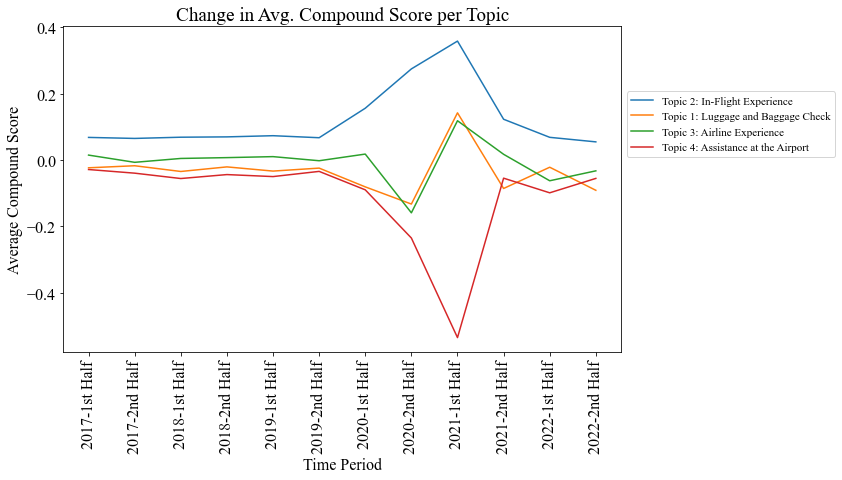

In [70]:
# Specify the topics of interest
topics_of_interest = [
    'Topic 2: In-Flight Experience',
    #'Topic 8: Seating and Classes',
    #'Topic 5: Ticketing and Booking',
    #'Topic 6: Customer Service and Refunds',
    #'Topic 10: Flight Delays and Cancellations',
    'Topic 1: Luggage and Baggage Check',
    #'Topic 7: Boarding and Time Management',
    #'Topic 9: Staff Behavior and Travel Experience',
    'Topic 3: Airline Experience',
    #'Topic 0: Rest Topic',
    'Topic 4: Assistance at the Airport'
]

# Filter the data DataFrame to include only the topics of interest
filtered_data = data[data['topic_name'].isin(topics_of_interest)]

# Extract year and month from the 'date_flown' column
filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month

# Define a function to map month to half-year
def map_to_half_year(month):
    if month <= 6:
        return '1st Half'
    else:
        return '2nd Half'

# Map the month to half-year
filtered_data['half_year'] = filtered_data['month_flown'].map(map_to_half_year)

# Group the filtered data by 'year_flown', 'half_year', and 'topic_name' and calculate the average compound score in each group
topic_scores = filtered_data.groupby(['year_flown', 'half_year', 'topic_name'])['compound_score'].mean().unstack()

# Merge the topic scores and half-year totals dataframes
topic_scores = pd.merge(topic_scores, half_year_totals, left_index=True, right_index=True)

# Calculate the average compound score per topic per half-year
topic_scores = topic_scores.div(topic_scores['review_count_hy'], axis=0) * 100

# Convert the multi-index into formatted strings for year and half-year
topic_scores.index = topic_scores.index.map(lambda x: f"{x[0]}-{x[1]}")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

for topic in topics_of_interest:
    ax.plot(topic_scores.index, topic_scores[topic], label=topic)

ax.legend()
ax.set_xlabel('Time Period')
ax.set_title('Change in Avg. Compound Score per Topic')
ax.set_ylabel('Average Compound Score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.7), fontsize='x-small')
plt.xticks(rotation=90)
plt.show()

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3573831300.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3573831300.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3573831300.py:31: SettingWithCopyWarning: 
A value is tryin

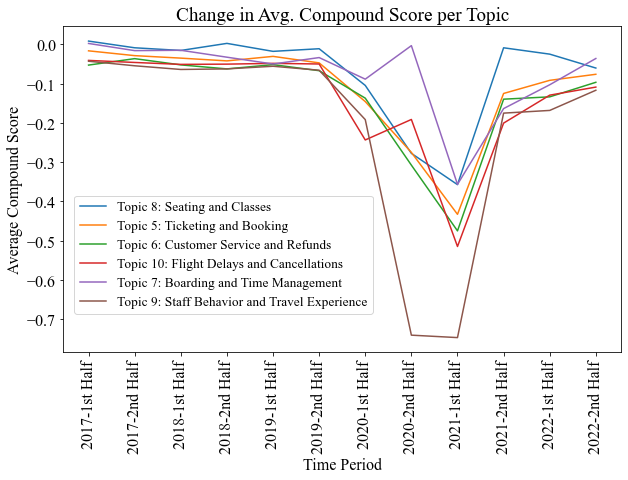

In [88]:
# Specify the topics of interest
topics_of_interest = [
    #'Topic 2: In-Flight Experience',
    'Topic 8: Seating and Classes',
    'Topic 5: Ticketing and Booking',
    'Topic 6: Customer Service and Refunds',
    'Topic 10: Flight Delays and Cancellations',
    #'Topic 1: Luggage and Baggage Check',
    'Topic 7: Boarding and Time Management',
    'Topic 9: Staff Behavior and Travel Experience',
    #'Topic 3: Airline Experience',
    #'Topic 0: Rest Topic',
    #'Topic 4: Assistance at the Airport'
]

# Filter the data DataFrame to include only the topics of interest
filtered_data = data[data['topic_name'].isin(topics_of_interest)]

# Extract year and month from the 'date_flown' column
filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month

# Define a function to map month to half-year
def map_to_half_year(month):
    if month <= 6:
        return '1st Half'
    else:
        return '2nd Half'

# Map the month to half-year
filtered_data['half_year'] = filtered_data['month_flown'].map(map_to_half_year)

# Group the filtered data by 'year_flown', 'half_year', and 'topic_name' and calculate the average compound score in each group
topic_scores = filtered_data.groupby(['year_flown', 'half_year', 'topic_name'])['compound_score'].mean().unstack()

# Merge the topic scores and half-year totals dataframes
topic_scores = pd.merge(topic_scores, half_year_totals, left_index=True, right_index=True)

# Calculate the average compound score per topic per half-year
topic_scores = topic_scores.div(topic_scores['review_count_hy'], axis=0) * 100

# Convert the multi-index into formatted strings for year and half-year
topic_scores.index = topic_scores.index.map(lambda x: f"{x[0]}-{x[1]}")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['purple', 'darkblue', 'darkgrey']  # Define the colors

for i, topic in enumerate(topics_of_interest):
    ax.plot(topic_scores.index, topic_scores[topic], label=topic) #color=colors[i])

ax.legend()

ax.set_xlabel('Time Period')
ax.set_title('Change in Avg. Compound Score per Topic')
ax.set_ylabel('Average Compound Score')
ax.legend(loc='center left', bbox_to_anchor=(0.008, 0.3), fontsize='small')
plt.xticks(rotation=90)
plt.show()


C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\2393980779.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\2393980779.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\2393980779.py:32: SettingWithCopyWarning: 
A value is tryin

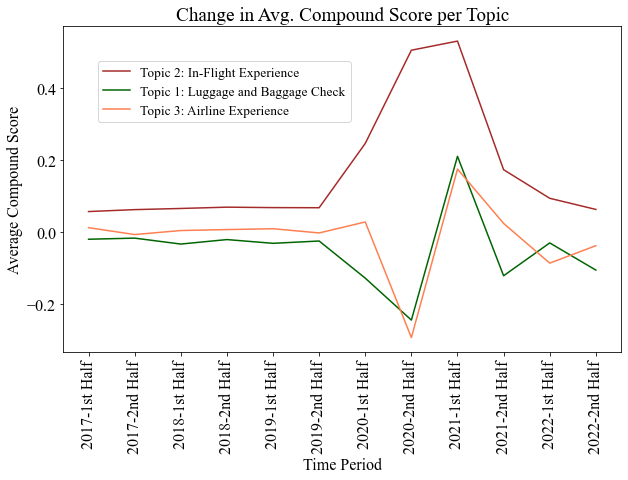

In [86]:
# Specify the topics of interest
topics_of_interest = [
    'Topic 2: In-Flight Experience',
    #'Topic 8: Seating and Classes',
    #'Topic 5: Ticketing and Booking',
    #'Topic 6: Customer Service and Refunds',
    #'Topic 10: Flight Delays and Cancellations',
    'Topic 1: Luggage and Baggage Check',
    #'Topic 7: Boarding and Time Management',
    #'Topic 9: Staff Behavior and Travel Experience',
    'Topic 3: Airline Experience',
    #'Topic 0: Rest Topic',
    #'Topic 4: Assistance at the Airport'
]


# Filter the data DataFrame to include only the topics of interest
filtered_data = data[data['topic_name'].isin(topics_of_interest)]

# Extract year and month from the 'date_flown' column
filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month

# Define a function to map month to half-year
def map_to_half_year(month):
    if month <= 6:
        return '1st Half'
    else:
        return '2nd Half'

# Map the month to half-year
filtered_data['half_year'] = filtered_data['month_flown'].map(map_to_half_year)

# Group the filtered data by 'year_flown', 'half_year', and 'topic_name' and calculate the average compound score in each group
topic_scores = filtered_data.groupby(['year_flown', 'half_year', 'topic_name'])['compound_score'].mean().unstack()

# Merge the topic scores and half-year totals dataframes
topic_scores = pd.merge(topic_scores, half_year_totals, left_index=True, right_index=True)

# Calculate the average compound score per topic per half-year
topic_scores = topic_scores.div(topic_scores['review_count_hy'], axis=0) * 100

# Convert the multi-index into formatted strings for year and half-year
topic_scores.index = topic_scores.index.map(lambda x: f"{x[0]}-{x[1]}")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['brown', 'darkgreen', 'coral']  # Define the colors

for i, topic in enumerate(topics_of_interest):
    ax.plot(topic_scores.index, topic_scores[topic], label=topic, color=colors[i])

ax.legend()
ax.set_xlabel('Time Period')
ax.set_title('Change in Avg. Compound Score per Topic')
ax.set_ylabel('Average Compound Score')
ax.legend(loc='center left', bbox_to_anchor=(0.05, 0.8), fontsize='small')
plt.xticks(rotation=90)
plt.show()

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3303817067.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3303817067.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_12692\3303817067.py:29: SettingWithCopyWarning: 
A value is tryin

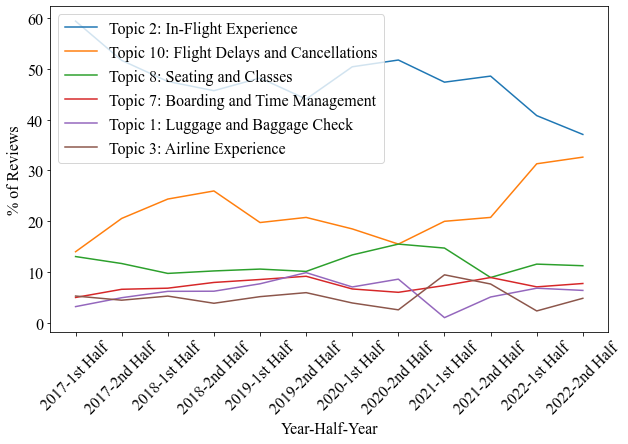

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the four topics of interest
topics_of_interest = [
    'Topic 2: In-Flight Experience',
    'Topic 10: Flight Delays and Cancellations',
    'Topic 8: Seating and Classes',
    'Topic 7: Boarding and Time Management',
    'Topic 1: Luggage and Baggage Check',
    'Topic 3: Airline Experience'
]

# Filter the data DataFrame to include only the topics of interest
filtered_data = data[data['topic_name'].isin(topics_of_interest)]

# Extract year and month from the 'date_flown' column
filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month

# Define a function to map month to half-year
def map_to_half_year(month):
    if month <= 6:
        return '1st Half'
    else:
        return '2nd Half'

# Map the month to half-year
filtered_data['half_year'] = filtered_data['month_flown'].map(map_to_half_year)

# Group the filtered data by 'year_flown', 'half_year', and 'topic_name' and count the reviews in each group
topic_counts = filtered_data.groupby(['year_flown', 'half_year', 'topic_name']).size().unstack()

# Calculate the total number of reviews per half-year
half_year_totals = filtered_data.groupby(['year_flown', 'half_year']).size()

# Convert half_year_totals to a DataFrame with a named column
half_year_totals = half_year_totals.to_frame(name='review_count_hy')

# Merge the topic counts and half-year totals dataframes
topic_percentages = pd.merge(topic_counts, half_year_totals, left_index=True, right_index=True)

# Calculate the percentage of reviews per topic per half-year
topic_percentages = topic_percentages.div(topic_percentages['review_count_hy'], axis=0) * 100

# Convert the multi-index into formatted strings for year and half-year
topic_percentages.index = topic_percentages.index.map(lambda x: f"{x[0]}-{x[1]}")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

for topic in topics_of_interest:
    ax.plot(topic_percentages.index, topic_percentages[topic], label=topic)

ax.legend()
ax.set_xlabel('Year-Half-Year')
ax.set_ylabel('% of Reviews')
plt.xticks(rotation=45)
plt.show()

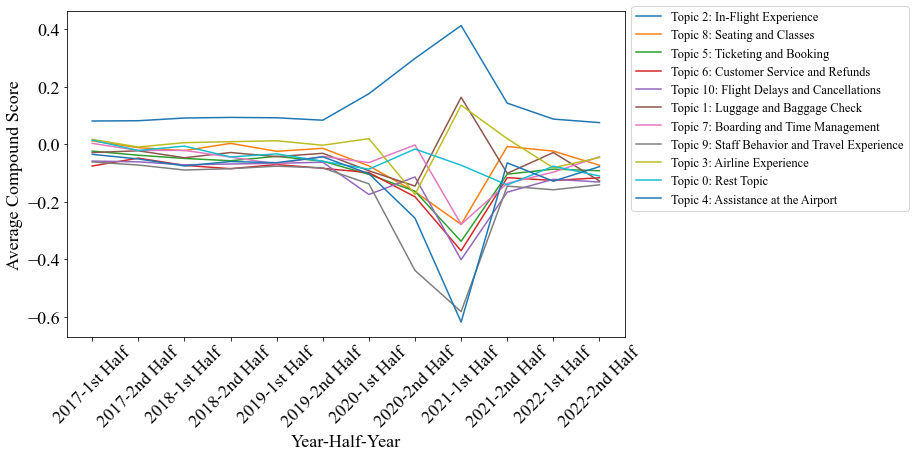

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the topics of interest
topics_of_interest = [
    'Topic 2: In-Flight Experience',
    'Topic 8: Seating and Classes',
    'Topic 5: Ticketing and Booking',
    'Topic 6: Customer Service and Refunds',
    'Topic 10: Flight Delays and Cancellations',
    'Topic 1: Luggage and Baggage Check',
    'Topic 7: Boarding and Time Management',
    'Topic 9: Staff Behavior and Travel Experience',
    'Topic 3: Airline Experience',
    'Topic 0: Rest Topic',
    'Topic 4: Assistance at the Airport'
]

# Filter the data DataFrame to include only the topics of interest
filtered_data = data[data['topic_name'].isin(topics_of_interest)]

# Extract year and month from the 'date_flown' column
filtered_data['year_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.year
filtered_data['month_flown'] = pd.to_datetime(filtered_data['date_flown']).dt.month

# Define a function to map month to half-year
def map_to_half_year(month):
    if month <= 6:
        return '1st Half'
    else:
        return '2nd Half'

# Map the month to half-year
filtered_data['half_year'] = filtered_data['month_flown'].map(map_to_half_year)

# Group the filtered data by 'year_flown', 'half_year', and 'topic_name' and calculate the average compound score in each group
topic_scores = filtered_data.groupby(['year_flown', 'half_year', 'topic_name'])['compound_score'].mean().unstack()

# Merge the topic scores and half-year totals dataframes
topic_scores = pd.merge(topic_scores, half_year_totals, left_index=True, right_index=True)

# Calculate the average compound score per topic per half-year
topic_scores = topic_scores.div(topic_scores['review_count_hy'], axis=0) * 100

# Convert the multi-index into formatted strings for year and half-year
topic_scores.index = topic_scores.index.map(lambda x: f"{x[0]}-{x[1]}")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))

for topic in topics_of_interest:
    ax.plot(topic_scores.index, topic_scores[topic], label=topic)

ax.legend()
ax.set_xlabel('Year-Half-Year')
ax.set_ylabel('Average Compound Score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.7), fontsize='x-small')
plt.xticks(rotation=45)
plt.show()




In [13]:
print(data['topic_name'].unique())


['Topic 2: In-Flight Experience' 'Topic 8: Seating and Classes'
 'Topic 5: Ticketing and Booking' 'Topic 6: Customer Service and Refunds'
 'Topic 10: Flight Delays and Cancellations'
 'Topic 1: Luggage and Baggage Check'
 'Topic 7: Boarding and Time Management'
 'Topic 9: Staff Behavior and Travel Experience'
 'Topic 3: Airline Experience' 'Topic 0: Rest Topic'
 'Topic 4: Assistance at the Airport']


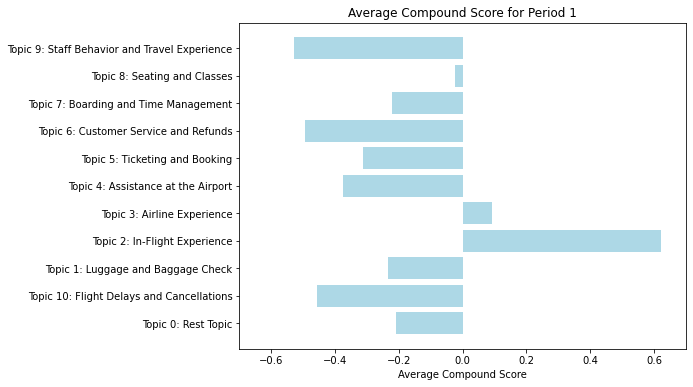

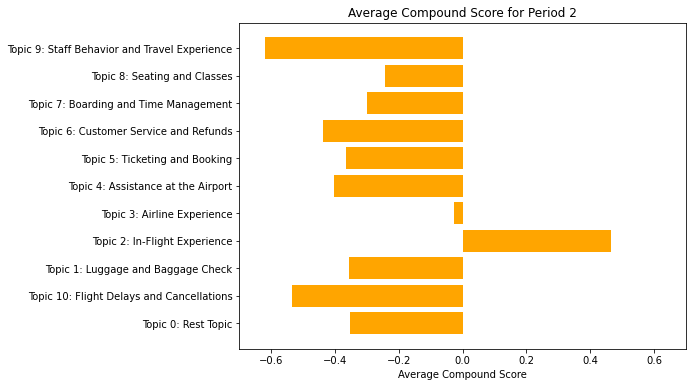

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the data by 'period' and 'topic_names' and calculate the mean of 'compound_score'
avg_scores = data.groupby(['period', 'topic_name'])['compound_score'].mean().reset_index()

# Filter the data for period 1
period1_scores = avg_scores[avg_scores['period'] == 0]

# Filter the data for period 2
period2_scores = avg_scores[avg_scores['period'] == 1]

# Sort the tables by the 'topic_name' column in ascending order
period1_scores = period1_scores.sort_values('topic_name')
period2_scores = period2_scores.sort_values('topic_name')


# Plot the horizontal bar graph for period 1
fig, ax1 = plt.subplots(figsize=(8, 6))
y_pos1 = range(len(period1_scores))
ax1.barh(y_pos1, period1_scores['compound_score'], align='center', color='lightblue')
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(period1_scores['topic_name'])
ax1.set_xlabel('Average Compound Score')
ax1.set_title('Average Compound Score for Period 1')
ax1.set_xlim(-0.7, 0.7)  # Set the x-axis limits

# Plot the horizontal bar graph for period 2
fig, ax2 = plt.subplots(figsize=(8, 6))
y_pos2 = range(len(period2_scores))
ax2.barh(y_pos2, period2_scores['compound_score'], align='center', color='orange')
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(period2_scores['topic_name'])
ax2.set_xlabel('Average Compound Score')
ax2.set_title('Average Compound Score for Period 2')
ax2.set_xlim(-0.7, 0.7)  # Set the x-axis limits

# Show the plots
plt.show()



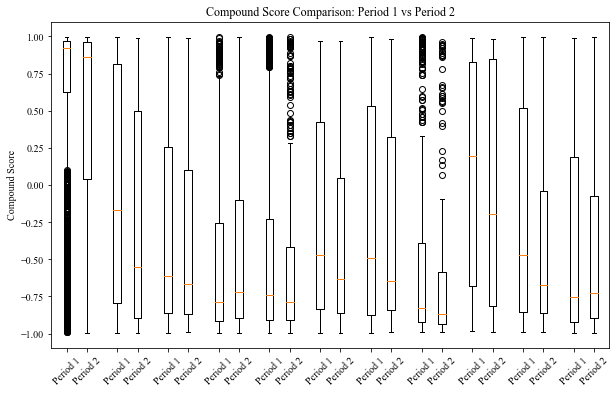

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for Period 1 and Period 2
period1_data = data[data['period'] == 0]
period2_data = data[data['period'] == 1]

# Group the data by 'topic_name' and 'period' and extract the 'compound_score' column
grouped_data = data.groupby(['topic_name', 'period'])['compound_score'].apply(list).reset_index()

# Create a figure and axes for the boxplot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over the topics
topics = data['topic_name'].unique()
for i, topic in enumerate(topics, start=1):
    # Get the compound scores for Period 1 and Period 2 for the current topic
    period1_scores = grouped_data[(grouped_data['topic_name'] == topic) & (grouped_data['period'] == 0)]['compound_score'].values[0]
    period2_scores = grouped_data[(grouped_data['topic_name'] == topic) & (grouped_data['period'] == 1)]['compound_score'].values[0]

    # Create the boxplot for the current topic
    positions = [i - 0.2, i + 0.2]  # Adjust the positions for each boxplot
    ax.boxplot([period1_scores, period2_scores], positions=positions, labels=['Period 1', 'Period 2'])

# Set the y-axis label
ax.set_ylabel('Compound Score')

# Set the title of the plot
ax.set_title('Compound Score Comparison: Period 1 vs Period 2')

# Set the x-axis limits
ax.set_xlim(0.5, len(topics) + 0.5)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()




In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by topic_name and overall_sentiment and calculate the count
sentiment_counts = data.groupby(['topic_name', 'overall_sentiment']).size().unstack()

# Calculate the total count per topic
total_counts = sentiment_counts.sum(axis=1)

# Calculate the percentage of each sentiment per topic
percentage_positive = (sentiment_counts['Positive'] / total_counts) * 100
percentage_negative = (sentiment_counts['Negative'] / total_counts) * 100
percentage_neutral = (sentiment_counts['Neutral'] / total_counts) * 100

# Get the topics and their indices
topics = sentiment_counts.index
indices = np.arange(len(topics))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# Convert the percentage values to lists
percentage_positive_period1 = percentage_positive[0].values.tolist()
percentage_negative_period1 = percentage_negative[0].values.tolist()
percentage_neutral_period1 = percentage_neutral[0].values.tolist()

percentage_positive_period2 = percentage_positive[1].values.tolist()
percentage_negative_period2 = percentage_negative[1].values.tolist()
percentage_neutral_period2 = percentage_neutral[1].values.tolist()

# Plot the bar chart for Period 1
for i, topic in enumerate(topics):
    plt.bar(indices[i] - bar_width/2, percentage_positive_period1[i], width=bar_width/3, label='Positive', color='lightgreen')
    plt.bar(indices[i] - bar_width/2, percentage_negative_period1[i], width=bar_width/3, bottom=percentage_positive_period1[i], label='Negative', color='red')
    plt.bar(indices[i] - bar_width/2, percentage_neutral_period1[i], width=bar_width/3, bottom=percentage_positive_period1[i] + percentage_negative_period1[i], label='Neutral', color='gray')

# Plot the bar chart for Period 2
for i, topic in enumerate(topics):
    plt.bar(indices[i] + bar_width/2, percentage_positive_period2[i], width=bar_width/3, label='Positive', color='lightgreen', alpha=0.5)
    plt.bar(indices[i] + bar_width/2, percentage_negative_period2[i], width=bar_width/3, bottom=percentage_positive_period2[i], label='Negative', color='red', alpha=0.5)
    plt.bar(indices[i] + bar_width/2, percentage_neutral_period2[i], width=bar_width/3, bottom=percentage_positive_period2[i] + percentage_negative_period2[i], label='Neutral', color='gray', alpha=0.5)

# Set the x-axis ticks and labels
plt.xticks(indices, topics, rotation=90)

# Set the plot title and axes labels
plt.title('Percentage of Reviews by Sentiment for Each Topic')
plt.xlabel('Topic')
plt.ylabel('Percentage')

# Add a legend
plt.legend()

# Show the plot
plt.show()


AttributeError: 'numpy.float64' object has no attribute 'values'

<Figure size 720x432 with 0 Axes>

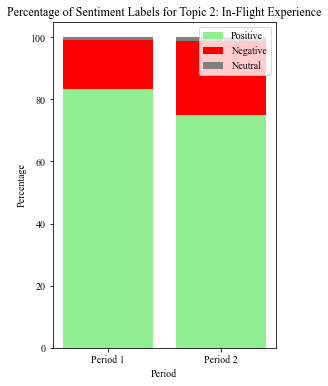

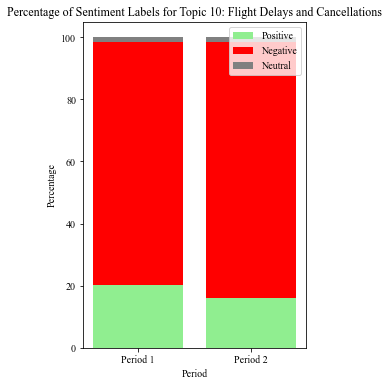

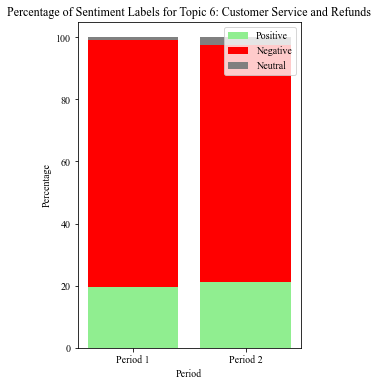

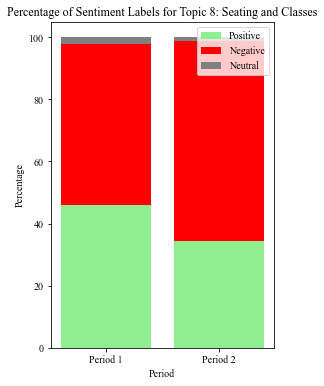

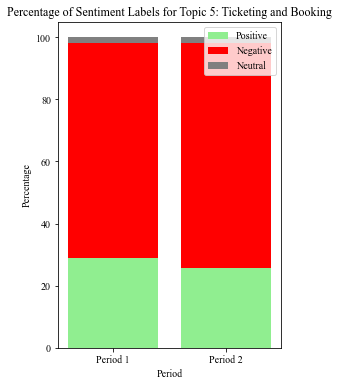

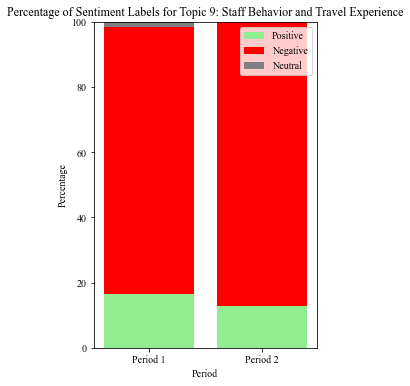

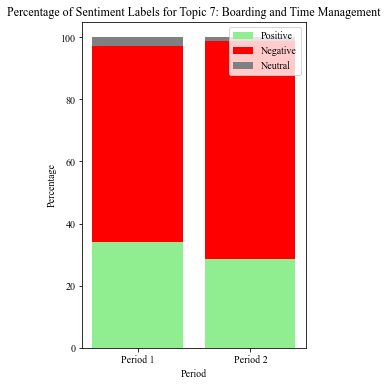

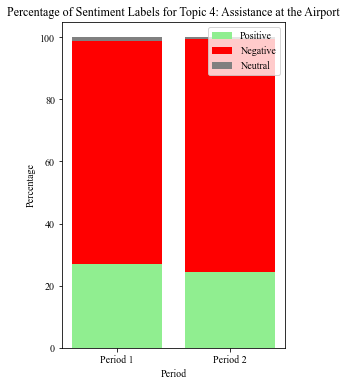

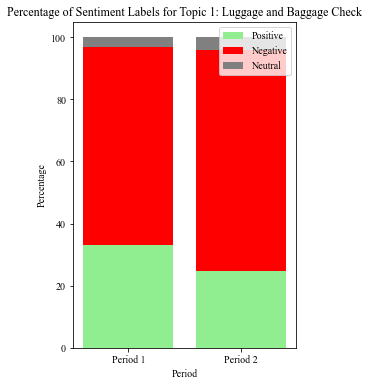

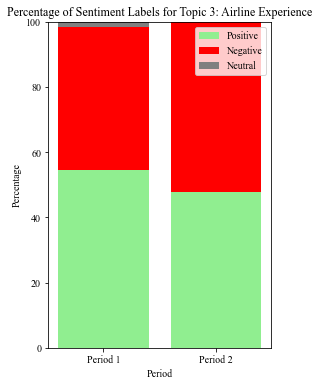

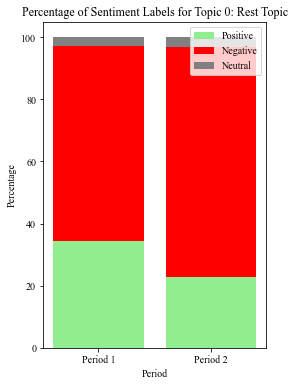

In [109]:
import matplotlib.pyplot as plt

# List of topics
topics = [
    'Topic 2: In-Flight Experience',
    'Topic 10: Flight Delays and Cancellations',
    'Topic 6: Customer Service and Refunds',
    'Topic 8: Seating and Classes',
    'Topic 5: Ticketing and Booking',
    'Topic 9: Staff Behavior and Travel Experience',
    'Topic 7: Boarding and Time Management',
    'Topic 4: Assistance at the Airport',
    'Topic 1: Luggage and Baggage Check',
    'Topic 3: Airline Experience',
    'Topic 0: Rest Topic'
]

# Iterate over each topic
for topic in topics:
    # Filter the data for the current topic
    topic_data = data[data['topic_name'] == topic]

    # Group the filtered data by period and overall sentiment and calculate the count
    sentiment_counts = topic_data.groupby(['period', 'overall_sentiment']).size().unstack()

    # Calculate the total count per period
    total_counts = sentiment_counts.sum(axis=1)

    # Calculate the percentage of each sentiment per period
    percentage_positive = (sentiment_counts['Positive'] / total_counts) * 100
    percentage_negative = (sentiment_counts['Negative'] / total_counts) * 100
    percentage_neutral = (sentiment_counts['Neutral'] / total_counts) * 100

    # Set the figure size
    plt.figure(figsize=(4, 6))

    # Set the positions of the bars on the x-axis
    bar_positions = [1, 2]

    # Plot the bars for each sentiment with stacking
    plt.bar(bar_positions, percentage_positive, label='Positive', color='lightgreen')
    plt.bar(bar_positions, percentage_negative, bottom=percentage_positive, label='Negative', color='red')
    plt.bar(bar_positions, percentage_neutral, bottom=percentage_positive + percentage_negative, label='Neutral', color='gray')

    # Set the x-axis ticks and labels
    plt.xticks(bar_positions, ['Period 1', 'Period 2'])
    plt.xlabel('Period')
    plt.ylabel('Percentage')

    # Set the plot title
    plt.title(f'Percentage of Sentiment Labels for {topic}')

    # Add a legend to the right on the top
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (22).

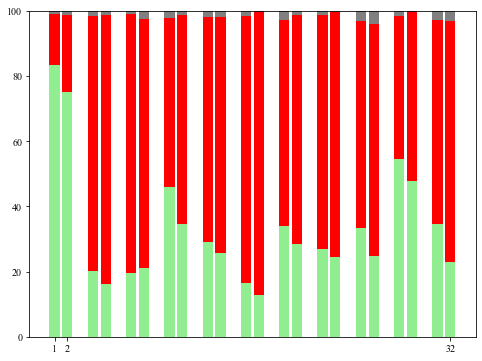

In [106]:
import matplotlib.pyplot as plt

# List of topics
topics = [
    'Topic 2: In-Flight Experience',
    'Topic 10: Flight Delays and Cancellations',
    'Topic 6: Customer Service and Refunds',
    'Topic 8: Seating and Classes',
    'Topic 5: Ticketing and Booking',
    'Topic 9: Staff Behavior and Travel Experience',
    'Topic 7: Boarding and Time Management',
    'Topic 4: Assistance at the Airport',
    'Topic 1: Luggage and Baggage Check',
    'Topic 3: Airline Experience',
    'Topic 0: Rest Topic'
]

# Set the figure size
plt.figure(figsize=(8, 6))

# Set the positions of the bars on the x-axis
bar_positions = [1, 2]

# Iterate over each topic
for i, topic in enumerate(topics):
    # Filter the data for the current topic
    topic_data = data[data['topic_name'] == topic]

    # Group the filtered data by period and overall sentiment and calculate the count
    sentiment_counts = topic_data.groupby(['period', 'overall_sentiment']).size().unstack()

    # Calculate the total count per period
    total_counts = sentiment_counts.sum(axis=1)

    # Calculate the percentage of each sentiment per period
    percentage_positive = (sentiment_counts['Positive'] / total_counts) * 100
    percentage_negative = (sentiment_counts['Negative'] / total_counts) * 100
    percentage_neutral = (sentiment_counts['Neutral'] / total_counts) * 100

    # Plot the bars for each sentiment with stacking
    plt.bar(bar_positions, percentage_positive, label='Positive', color='lightgreen')
    plt.bar(bar_positions, percentage_negative, bottom=percentage_positive, label='Negative', color='red')
    plt.bar(bar_positions, percentage_neutral, bottom=percentage_positive + percentage_negative, label='Neutral', color='gray')

    # Shift the positions for the next topic
    bar_positions = [p + 3 for p in bar_positions]

# Set the x-axis ticks and labels
plt.xticks([1, 2, 3*len(topics)-1], ['Period 1', 'Period 2'] * len(topics))
plt.xlabel('Period')
plt.ylabel('Percentage')

# Set the plot title
plt.title('Percentage of Sentiment Labels for Each Topic')

# Add a legend to the right on the top
plt.legend(loc='upper right')

# Show the plot
plt.show()


## Changepoint analysis

Topic 3 

In [22]:
import pandas as pd

data['date_flown'] = pd.to_datetime(data['date_flown'], errors='coerce')

# Filter the dataset to select the specified period
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2022-12-31')
topic_name = 'Topic 3: Airline Experience'
filtered_data = data[(data['date_flown'] >= start_date) & (data['date_flown'] <= end_date)]
filtered_data_topic3 = data[(data['topic_name'] == topic_name)]

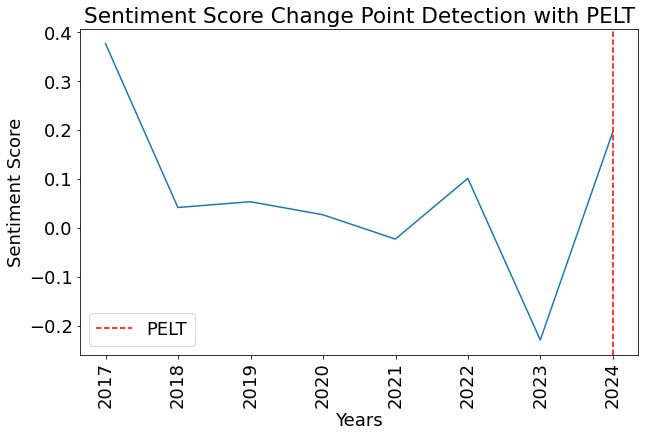

In [35]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib
import matplotlib.pyplot as plt

# Extract the sentiment scores and corresponding month values from the DataFrame
data = filtered_data_topic3['compound_score'].values
months = pd.to_datetime(filtered_data_topic3['date_flown'])

# Create a Pandas Series with sentiment scores and month values
series = pd.Series(data=data, index=months)

# Resample the series to monthly frequency
series_monthly = series.resample('Y').mean()

# PELT (Pruned Exact Linear Time)
penalty = 5  # Adjust the penalty value
algo_pelt = rpt.Pelt(model="rbf").fit(series_monthly.values[:, np.newaxis])
result_pelt = algo_pelt.predict(pen=penalty)

# Visualize the change points
plt.figure(figsize=(10, 6))
plt.plot(series_monthly.index, series_monthly.values)
plt.title("Sentiment Score Change Point Detection with PELT")
plt.xlabel("Years")
plt.ylabel("Sentiment Score")
matplotlib.rcParams.update({'font.size': 18})


# Plot vertical lines for the detected change points (PELT)
for cp in result_pelt:
    plt.axvline(x=series_monthly.index[cp-1], color='red', linestyle='--', label='PELT')

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [26]:
data = pd.read_csv('topic_modelling_data.csv')

In [27]:
import pandas as pd

data['date_flown'] = pd.to_datetime(data['date_flown'], errors='coerce')

# Filter the dataset to select the specified period
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2022-12-31')
topic_name = 'Topic 8: Seating and Classes'
filtered_data = data[(data['date_flown'] >= start_date) & (data['date_flown'] <= end_date)]
filtered_data_topic8 = data[(data['topic_name'] == topic_name)]

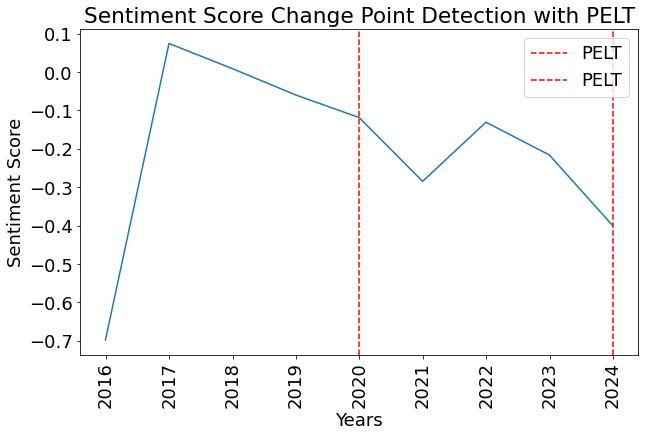

In [34]:
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib
import matplotlib.pyplot as plt

# Extract the sentiment scores and corresponding month values from the DataFrame
data = filtered_data_topic8['compound_score'].values
months = pd.to_datetime(filtered_data_topic8['date_flown'])

# Create a Pandas Series with sentiment scores and month values
series = pd.Series(data=data, index=months)

# Resample the series to monthly frequency
series_monthly = series.resample('Y').mean()

# PELT (Pruned Exact Linear Time)
penalty = 1  # Adjust the penalty value
algo_pelt = rpt.Pelt(model="rbf").fit(series_monthly.values[:, np.newaxis])
result_pelt = algo_pelt.predict(pen=penalty)

# Visualize the change points
plt.figure(figsize=(10, 6))
plt.plot(series_monthly.index, series_monthly.values)
plt.title("Sentiment Score Change Point Detection with PELT")
plt.xlabel("Years")
plt.ylabel("Sentiment Score")
matplotlib.rcParams.update({'font.size': 18})


# Plot vertical lines for the detected change points (PELT)
for cp in result_pelt:
    plt.axvline(x=series_monthly.index[cp-1], color='red', linestyle='--', label='PELT')

plt.xticks(rotation=90)
plt.legend()
plt.show()

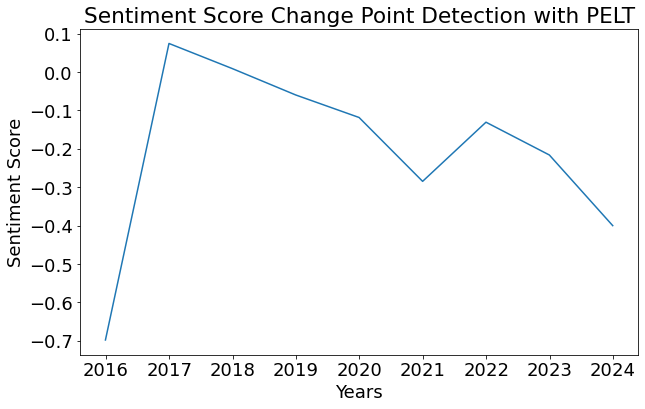

In [33]:
# Extract the sentiment scores and corresponding month values from the DataFrame
data = filtered_data_topic8['compound_score'].values
months = pd.to_datetime(filtered_data_topic8['date_flown'])

# Create a Pandas Series with sentiment scores and month values
series = pd.Series(data=data, index=months)

# Resample the series to monthly frequency
series_monthly = series.resample('Y').mean()

# Visualize the change points
plt.figure(figsize=(10, 6))
plt.plot(series_monthly.index, series_monthly.values)
plt.title("Sentiment Score Change Point Detection with PELT")
plt.xlabel("Years")
plt.ylabel("Sentiment Score")
matplotlib.rcParams.update({'font.size': 18})